<a href="https://colab.research.google.com/github/abhi220501/EE769-Cource-Project/blob/main/Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip -q /content/drive/MyDrive/defo_dataset_half.zip

In [ ]:
!unzip -q /content/drive/MyDrive/dataset_defonet.zip

In [ ]:
!unzip -q /content/drive/MyDrive/dataset_defo.zip

warning [/content/drive/MyDrive/dataset_defo.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/drive/MyDrive/dataset_defo.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #97402).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [ ]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset)))  \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.train_labels[idx].item()
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [ ]:
pip install torchsampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchsampler import ImbalancedDatasetSampler

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],sampler=ImbalancedDatasetSampler(image_datasets[x]), batch_size=4, 
                                              num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


Visualize a few images



Let's visualize a few training images so as to understand the data augmentations.

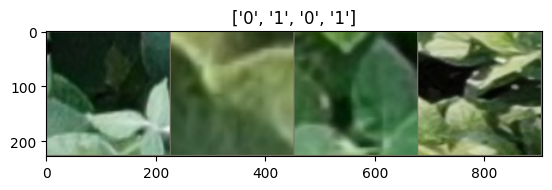

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model:

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 40.9MB/s]


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------
train Loss: 0.7767 Acc: 0.6416
test Loss: 0.6025 Acc: 0.7267

Epoch 1/5
----------
train Loss: 0.7656 Acc: 0.6413
test Loss: 0.5395 Acc: 0.7366

Epoch 2/5
----------
train Loss: 0.5919 Acc: 0.6823
test Loss: 0.5359 Acc: 0.7189

Epoch 3/5
----------
train Loss: 0.5873 Acc: 0.6803
test Loss: 0.4977 Acc: 0.7527

Epoch 4/5
----------
train Loss: 0.5707 Acc: 0.6891
test Loss: 0.5094 Acc: 0.7360

Epoch 5/5
----------
train Loss: 0.5711 Acc: 0.6912
test Loss: 0.4928 Acc: 0.7506

Training complete in 40m 16s
Best val Acc: 0.752668


In [ ]:
model_conv.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_conv.epochs = 20
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_conv.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_conv.state_dict(),
                  'class_to_idx': model_conv.class_to_idx,
                  'epoch': model_conv.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved Models/soyabean_resnet18_20_withIDS.pth')

In [ ]:
loaded_checkpoint = torch.load('/content/drive/MyDrive/Saved Models/soyabean_resnet18_6_withIDS.pth')
model_conv.load_state_dict(loaded_checkpoint['state_dict'])
optimizer_conv.load_state_dict(loaded_checkpoint['optimizer_dict'])

In [ ]:
#7-20 epochs
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=14)

Epoch 0/13
----------
train Loss: 0.5708 Acc: 0.6878
test Loss: 0.4951 Acc: 0.7510

Epoch 1/13
----------
train Loss: 0.5742 Acc: 0.6889
test Loss: 0.4868 Acc: 0.7584

Epoch 2/13
----------
train Loss: 0.5715 Acc: 0.6907
test Loss: 0.5005 Acc: 0.7454

Epoch 3/13
----------
train Loss: 0.5674 Acc: 0.6928
test Loss: 0.5027 Acc: 0.7497

Epoch 4/13
----------
train Loss: 0.5722 Acc: 0.6889
test Loss: 0.4891 Acc: 0.7560

Epoch 5/13
----------
train Loss: 0.5701 Acc: 0.6901
test Loss: 0.4905 Acc: 0.7569

Epoch 6/13
----------
train Loss: 0.5690 Acc: 0.6897
test Loss: 0.4981 Acc: 0.7531

Epoch 7/13
----------
train Loss: 0.5705 Acc: 0.6912
test Loss: 0.4948 Acc: 0.7501

Epoch 8/13
----------
train Loss: 0.5672 Acc: 0.6927
test Loss: 0.5148 Acc: 0.7301

Epoch 9/13
----------
train Loss: 0.5713 Acc: 0.6889
test Loss: 0.4784 Acc: 0.7636

Epoch 10/13
----------
train Loss: 0.5696 Acc: 0.6907
test Loss: 0.4961 Acc: 0.7513

Epoch 11/13
----------
train Loss: 0.5726 Acc: 0.6870
test Loss: 0.4844 Acc

In [ ]:
#13-20 epochs


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.05)


In [ ]:
loaded_checkpoint = torch.load('/content/drive/MyDrive/Saved Models/soyabean_resnet18_ft_6_withIDS.pth')
model_ft.load_state_dict(loaded_checkpoint['state_dict'])
optimizer_ft.load_state_dict(loaded_checkpoint['optimizer_dict'])

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------
train Loss: 0.3713 Acc: 0.8087
test Loss: 0.3277 Acc: 0.8493

Epoch 1/7
----------
train Loss: 0.3743 Acc: 0.8068
test Loss: 0.3111 Acc: 0.8528

Epoch 2/7
----------
train Loss: 0.3713 Acc: 0.8115
test Loss: 0.3211 Acc: 0.8588

Epoch 3/7
----------
train Loss: 0.3698 Acc: 0.8113
test Loss: 0.3056 Acc: 0.8623

Epoch 4/7
----------
train Loss: 0.3714 Acc: 0.8096
test Loss: 0.3141 Acc: 0.8576

Epoch 5/7
----------
train Loss: 0.3719 Acc: 0.8089
test Loss: 0.3191 Acc: 0.8556

Epoch 6/7
----------
train Loss: 0.3722 Acc: 0.8084
test Loss: 0.3112 Acc: 0.8583

Epoch 7/7
----------
train Loss: 0.3716 Acc: 0.8103
test Loss: 0.3197 Acc: 0.8573

Training complete in 78m 45s
Best val Acc: 0.862332


In [ ]:
#9-20 epochs
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=12)

Epoch 0/11
----------
train Loss: 0.3694 Acc: 0.8104
test Loss: 0.3261 Acc: 0.8538

Epoch 1/11
----------
train Loss: 0.3709 Acc: 0.8109
test Loss: 0.3182 Acc: 0.8610

Epoch 2/11
----------
train Loss: 0.3724 Acc: 0.8096
test Loss: 0.3115 Acc: 0.8610

Epoch 3/11
----------
train Loss: 0.3718 Acc: 0.8088
test Loss: 0.3161 Acc: 0.8625

Epoch 4/11
----------
train Loss: 0.3727 Acc: 0.8087
test Loss: 0.3185 Acc: 0.8534

Epoch 5/11
----------
train Loss: 0.3681 Acc: 0.8126
test Loss: 0.3146 Acc: 0.8541

Epoch 6/11
----------
train Loss: 0.3682 Acc: 0.8117
test Loss: 0.3012 Acc: 0.8670

Epoch 7/11
----------
train Loss: 0.3722 Acc: 0.8083
test Loss: 0.3212 Acc: 0.8558

Epoch 8/11
----------
train Loss: 0.3708 Acc: 0.8100
test Loss: 0.3177 Acc: 0.8533

Epoch 9/11
----------
train Loss: 0.3725 Acc: 0.8096
test Loss: 0.3136 Acc: 0.8539

Epoch 10/11
----------
train Loss: 0.3693 Acc: 0.8122
test Loss: 0.3172 Acc: 0.8509

Epoch 11/11
----------
train Loss: 0.3730 Acc: 0.8077
test Loss: 0.3209 Acc

In [ ]:
model_ft.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_ft.epochs = 20
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_ft.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_ft.state_dict(),
                  'class_to_idx': model_ft.class_to_idx,
                  'epoch': model_ft.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved Models/soyabean_resnet18_ft_20_withIDS.pth')

In [ ]:
#Testing
from torch.autograd import Variable

def test(model, dataloaders, device):
    model.eval()
    accuracy = 0
      
    preds = []
    actual = []
    for images, labels in dataloaders['test']:
        images = Variable(images)
        labels = Variable(labels)
        images, labels = images.to(device), labels.to(device)
          
        output = model.forward(images)
        ps = torch.exp(output)
        preds.append(np.array(ps.max(1)[1].cpu()))
        actual.append(np.array(labels.data.cpu()))
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    preds = np.array(preds, dtype=object)
    actual = np.array(actual, dtype=object)
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))
    return np.concatenate(preds), np.concatenate(actual)

In [ ]:
preds, actual = test(model_ft, dataloaders, device)
preds #thisis for half data

Testing Accuracy: 0.868


array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
preds_conv, actual_conv = test(model_conv, dataloaders, device)
preds_conv

Testing Accuracy: 0.754


array([0, 0, 0, ..., 1, 1, 0])

[Text(0.5, 25.722222222222214, 'Predicted Labels'),
 Text(33.222222222222214, 0.5, 'Actual Labels')]

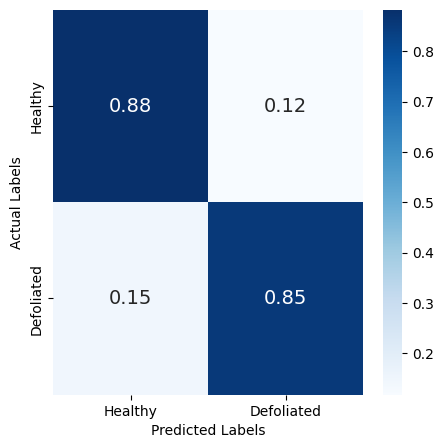

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns


cm = confusion_matrix(preds, actual, normalize='true')
df_cm = pd.DataFrame(cm, index = ['Healthy', 'Defoliated'], 
                     columns = ['Healthy', 'Defoliated'])

plt.figure(figsize=(5, 5))
s = sns.heatmap(df_cm, annot=True, cmap="Blues", 
            annot_kws={
                'fontsize': 14
            })
s.set(xlabel='Predicted Labels', ylabel='Actual Labels')

[Text(0.5, 25.722222222222214, 'Predicted Labels'),
 Text(33.222222222222214, 0.5, 'Actual Labels')]

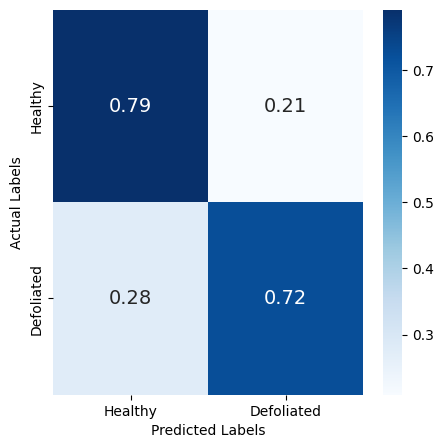

In [ ]:
#For fine tuned on conv net only
cm = confusion_matrix(preds_conv, actual_conv, normalize='true')
df_cm = pd.DataFrame(cm, index = ['Healthy', 'Defoliated'], 
                     columns = ['Healthy', 'Defoliated'])

plt.figure(figsize=(5, 5))
s = sns.heatmap(df_cm, annot=True, cmap="Blues", 
            annot_kws={
                'fontsize': 14
            })
s.set(xlabel='Predicted Labels', ylabel='Actual Labels')

In [ ]:
#For fully trained
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(f1_score(actual, preds, average="binary"))
print(precision_score(actual, preds, average="binary"))
print(recall_score(actual, preds, average="binary"))  

0.8714977680691424
0.8537402307406029
0.8900096993210476


In [ ]:
#Fine tuning on conv net

print(f1_score(actual_conv, preds_conv, average="binary"))
print(precision_score(actual_conv, preds_conv, average="binary"))
print(recall_score(actual_conv, preds_conv, average="binary"))  

0.7631082610335722
0.7237924865831843
0.8069405664140407


####Using HALF DATASET

In [ ]:
from torchsampler import ImbalancedDatasetSampler

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/defo_dataset_half'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],sampler=ImbalancedDatasetSampler(image_datasets[x]), batch_size=4, 
                                              num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.05)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 301MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=6)


Epoch 0/5
----------
train Loss: 0.4708 Acc: 0.7783
test Loss: 0.4037 Acc: 0.7957

Epoch 1/5
----------
train Loss: 0.3311 Acc: 0.8459
test Loss: 0.4115 Acc: 0.8020

Epoch 2/5
----------
train Loss: 0.2747 Acc: 0.8716
test Loss: 0.4392 Acc: 0.7969

Epoch 3/5
----------
train Loss: 0.2676 Acc: 0.8742
test Loss: 0.4133 Acc: 0.7998

Epoch 4/5
----------
train Loss: 0.2663 Acc: 0.8755
test Loss: 0.4249 Acc: 0.8071

Epoch 5/5
----------
train Loss: 0.2641 Acc: 0.8772
test Loss: 0.4158 Acc: 0.8094

Training complete in 28m 30s
Best val Acc: 0.809361


In [ ]:
model_ft.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_ft.epochs = 6
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_ft.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_ft.state_dict(),
                  'class_to_idx': model_ft.class_to_idx,
                  'epoch': model_ft.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved Models/soyabean_resnet18_ft_6_withHalfData.pth')

In [ ]:
#For fully trained
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(f1_score(actual, preds, average="binary"))
print(precision_score(actual, preds, average="binary"))
print(recall_score(actual, preds, average="binary"))  

0.8184124001878815
0.7867076033953404
0.8527799530148786


Without pretraing...


In [ ]:
model_wo_pt = torchvision.models.resnet18(pretrained=False)


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_wo_pt.fc.in_features
model_wo_pt.fc = nn.Linear(num_ftrs, 2)

model_wo_pt = model_wo_pt.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_wo_pt = optim.SGD(model_wo_pt.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_wo_pt, step_size=2, gamma=0.05)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model_wo_pt = train_model(model_wo_pt, criterion, optimizer_wo_pt, exp_lr_scheduler,
                       num_epochs=6)

Epoch 0/5
----------
train Loss: 0.7182 Acc: 0.6181
test Loss: 0.5942 Acc: 0.7212

Epoch 1/5
----------
train Loss: 0.7061 Acc: 0.6311
test Loss: 0.4992 Acc: 0.7537

Epoch 2/5
----------
train Loss: 0.5923 Acc: 0.6711
test Loss: 0.4885 Acc: 0.7583

Epoch 3/5
----------
train Loss: 0.5898 Acc: 0.6720
test Loss: 0.4934 Acc: 0.7634

Epoch 4/5
----------
train Loss: 0.5882 Acc: 0.6719
test Loss: 0.4834 Acc: 0.7601

Epoch 5/5
----------
train Loss: 0.5893 Acc: 0.6711
test Loss: 0.5055 Acc: 0.7471

Training complete in 52m 56s
Best val Acc: 0.763439


In [ ]:
model_wo_pt.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_wo_pt.epochs = 6
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_wo_pt.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_wo_pt.state_dict(),
                  'class_to_idx': model_wo_pt.class_to_idx,
                  'epoch': model_wo_pt.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved Models/soyabean_resnet18_wo_pt_6.pth')

In [ ]:
preds, actual = test(model_wo_pt, dataloaders, device)
preds #thisis for half data

Testing Accuracy: 0.757


array([0, 1, 0, ..., 1, 1, 1])

[Text(0.5, 25.722222222222214, 'Predicted Labels'),
 Text(33.222222222222214, 0.5, 'Actual Labels')]

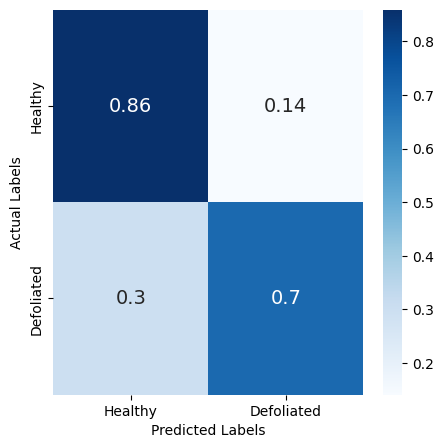

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns


cm = confusion_matrix(preds, actual, normalize='true')
df_cm = pd.DataFrame(cm, index = ['Healthy', 'Defoliated'], 
                     columns = ['Healthy', 'Defoliated'])

plt.figure(figsize=(5, 5))
s = sns.heatmap(df_cm, annot=True, cmap="Blues", 
            annot_kws={
                'fontsize': 14
            })
s.set(xlabel='Predicted Labels', ylabel='Actual Labels')

In [ ]:
#For fully trained
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(f1_score(actual, preds, average="binary"))
print(precision_score(actual, preds, average="binary"))
print(recall_score(actual, preds, average="binary"))  

0.7865071852680492
0.6996325780771586
0.8980153271762625
